In [1]:
from pivpy import io
from pivpy import graphics
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pkg_resources as pkg

In [2]:
# read the arrays
filename = pkg.resource_filename('pivpy','data/VC7/2Ca.VC7')
data = io.load_vc7(filename)

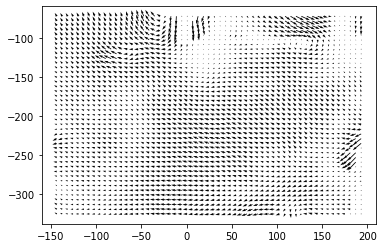

In [3]:
plt.quiver(data.x, data.y, data.u.isel(t=0).transpose(), data.v.isel(t=0).transpose())

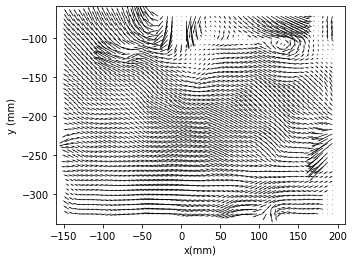

In [4]:
tmp = data.copy()

tmp['u'] = tmp['u'].transpose()
tmp['v'] = tmp['v'].transpose()

graphics.quiver(tmp.isel(t=0),arrScale=10);

In [5]:
# we created a shortcut to the above cells in pivpy.io
data = io.load_vc7( pkg.resource_filename('pivpy','data/VC7/2Cb.VC7'))
data['u'] = data['u'].transpose()
data['v'] = data['v'].transpose()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

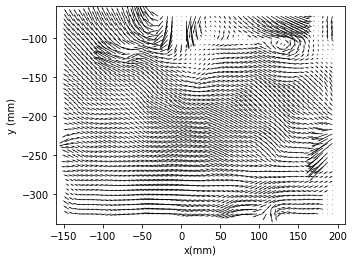

In [6]:
graphics.quiver(data,arrScale=10)